In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import re
import pickle
import random
import Levenshtein
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.tensorboard import SummaryWriter
from matplotlib import gridspec

In [2]:
data_dir = r"C:\Users\13658\Desktop\LaTex_Code_Generator"
handwritten_equations = os.path.join(data_dir, "Handwritten_equations")
json_dict = os.path.join(data_dir, "char_dict.json")
csv_file = os.path.join(data_dir, "caption_data.csv")

In [3]:
def smart_clean_latex(code):
    preserved = re.findall(r'(\\[a-zA-Z]+)\s+', code)
    for cmd in preserved:
        code = code.replace(cmd + ' ', f'{cmd}<<<SPACE>>>')
    code = code.replace(' ', '')
    code = code.replace('<<<SPACE>>>', ' ')
    return code

csv_data = pd.read_csv(csv_file)
latex_codes_raw = csv_data['Column2'].values.tolist()
latex_codes = [smart_clean_latex(code) for code in latex_codes_raw]
image_names = csv_data['Column1'].values.tolist()

In [4]:
command_tokens = set()
for code in latex_codes:
    i = 0
    while i < len(code):
        if code[i] == '\\':
            j = i + 1
            while j < len(code) and code[j].isalpha():
                j += 1
            command_tokens.add(code[i:j])
            i = j
        else:
            i += 1

def mixed_tokenize_latex(code, command_set):
    tokens = []
    i = 0
    while i < len(code):
        if code[i] == '\\':
            j = i + 1
            while j < len(code) and code[j].isalpha():
                j += 1
            cmd = code[i:j]
            if cmd in command_set:
                tokens.append(cmd)
                i = j
                continue
        tokens.append(code[i])
        i += 1
    return tokens

token_counter = Counter()
for code in latex_codes:
    tokens = mixed_tokenize_latex(code, command_tokens)
    token_counter.update(tokens)

special_tokens = ['<pad>', '<s>', '</s>']
token_list = special_tokens + sorted(token_counter.keys())

token2idx = {token: idx for idx, token in enumerate(token_list)}
idx2token = {idx: token for token, idx in token2idx.items()}
vocab_size = len(token2idx)

def encode_label_mixed(code, token2idx, command_set, max_len):
    tokens = ['<s>'] + mixed_tokenize_latex(code, command_set)[:max_len - 2] + ['</s>']
    label = np.zeros(max_len, dtype=np.int32)
    for t, token in enumerate(tokens):
        label[t] = token2idx.get(token, 0)
    return label

max_seq_length = max(len(mixed_tokenize_latex(code, command_tokens)) for code in latex_codes) + 2
print(f"Dic Length: {vocab_size}")
print(f"Maximum Sequence: {max_seq_length}")

Dic Length: 113
Maximum Sequence: 224


In [36]:
def preprocess_image(image_path, target_size=(464, 85)):
    img = Image.open(image_path).convert('L')
    img.thumbnail(target_size, Image.Resampling.LANCZOS)

    delta_w = target_size[0] - img.size[0]
    delta_h = target_size[1] - img.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    img = ImageOps.expand(img, padding, fill=255)

    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.repeat(img_array, 3, axis=0)
    return torch.from_numpy(img_array).float()



class LatexDataset(Dataset):
    def __init__(self, image_dir, image_names, latex_codes, max_len):
        self.image_dir = image_dir
        self.image_names = image_names
        self.latex_codes = latex_codes
        self.max_len = max_len

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, f"{self.image_names[idx]}.bmp")
        img = preprocess_image(img_path)
        label = encode_label_mixed(self.latex_codes[idx], token2idx, command_tokens, self.max_len)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img, label_tensor


def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)
    return images, labels, [len(l) for l in labels]

train_imgs, tep_imgs, train_codes, tep_codes = train_test_split(
    image_names, latex_codes, test_size=0.3, random_state=42)

val_imgs, test_imgs, val_codes, test_codes = train_test_split(
    tep_imgs, tep_codes, test_size=0.5, random_state=41)

train_dataset = LatexDataset(handwritten_equations, train_imgs, train_codes, max_seq_length)
val_dataset = LatexDataset(handwritten_equations, val_imgs, val_codes, max_seq_length)
test_dataset = LatexDataset(handwritten_equations, test_imgs, test_codes, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

token2idx/idx2token stored in C:\Users\13658\Desktop\LaTex_Code_Generator\token_dicts


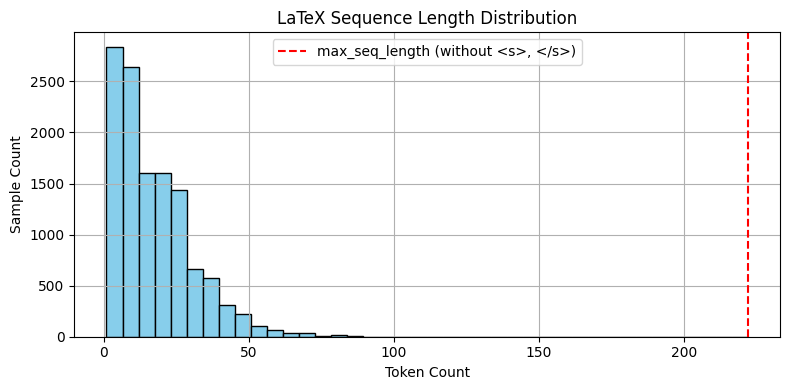

In [6]:
dict_dir = os.path.join(data_dir, "token_dicts")
os.makedirs(dict_dir, exist_ok=True)

with open(os.path.join(dict_dir, "token2idx.pkl"), "wb") as f:
    pickle.dump(token2idx, f)

with open(os.path.join(dict_dir, "idx2token.pkl"), "wb") as f:
    pickle.dump(idx2token, f)

print(f"token2idx/idx2token stored in {dict_dir}")

seq_lens = [len(mixed_tokenize_latex(code, command_tokens)) for code in latex_codes]
plt.figure(figsize=(8, 4))
plt.hist(seq_lens, bins=40, color='skyblue', edgecolor='black')
plt.axvline(max_seq_length - 2, color='red', linestyle='--', label='max_seq_length (without <s>, </s>)')
plt.title("LaTeX Sequence Length Distribution")
plt.xlabel("Token Count")
plt.ylabel("Sample Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Figure shape: torch.Size([3, 85, 464])
Label shape: torch.Size([224])


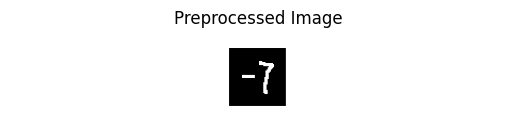

In [7]:
idx = random.randint(0, len(train_dataset) - 1)
img_tensor, label_tensor = train_dataset[idx]

print(f"Figure shape: {img_tensor.shape}")
print(f"Label shape: {label_tensor.shape}")

plt.imshow(img_tensor.permute(1, 2, 0).numpy(), cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()

In [8]:
sample_indices = random.sample(range(len(train_dataset)), 5)

for i, idx in enumerate(sample_indices, 1):
    img_tensor, label_tensor = train_dataset[idx]
    
    tokens = [idx2token[idx.item()] for idx in label_tensor 
              if idx.item() not in (token2idx['<pad>'], token2idx['<s>'], token2idx['</s>'])]
    decoded_latex = ' '.join(tokens)

    print(f"\nSample {i}")
    print("Token Length:", len(tokens))
    print("Restore the LaTeX expression:")
    print(decoded_latex)


Sample 1
Token Length: 3
Restore the LaTeX expression:
\cos   I

Sample 2
Token Length: 13
Restore the LaTeX expression:
Y = L \cos   ( s ) \sin   ( t )

Sample 3
Token Length: 13
Restore the LaTeX expression:
x ^ { 2 } + y ^ { 2 } < 1

Sample 4
Token Length: 35
Restore the LaTeX expression:
x _ { x } ^ { x } + y _ { y } ^ { y } + z _ { z } ^ { z } - x - y - z

Sample 5
Token Length: 50
Restore the LaTeX expression:
t ^ { \prime   } = \frac   { t - \frac   { v x } { c ^ { 2 } } } { \sqrt   { 1 - \frac   { v ^ { 2 } } { c ^ { 2 } } } }


In [9]:
sample_idx = random.randint(0, len(latex_codes_raw) - 1)
raw = latex_codes_raw[sample_idx]
cleaned = smart_clean_latex(raw)
encoded = encode_label_mixed(cleaned, token2idx, command_tokens, max_seq_length)

tokens = [idx2token[i] for i in encoded if i not in (token2idx['<pad>'], token2idx['<s>'], token2idx['</s>'])]
decoded = ''.join(tokens)

print("Original Lable:")
print(raw)
print("\nWashed:")
print(cleaned)
print("\nEncoded:")
print(encoded)
print("\nDecoded:")
print(decoded)

Original Lable:
b d = Y

Washed:
bd=Y

Encoded:
[ 1 85 87 24 43  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]

Decoded:
bd=Y


In [10]:
batch = next(iter(train_loader))
imgs, labels, lengths = batch

print(f"Batch figure shape: {imgs.shape}")
print(f"Batch label shape: {labels.shape}")
print(f"Label Length (first 5): {lengths[:5]}")

Batch figure shape: torch.Size([32, 3, 85, 464])
Batch label shape: torch.Size([32, 224])
Label Length (first 5): [224, 224, 224, 224, 224]


In [11]:
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, height, width):
        super().__init__()
        if d_model % 4 != 0:
            raise ValueError("d_model must be divisible by 4")

        self.d_model = d_model
        self.height = height
        self.width = width

        pe = torch.zeros(d_model, height, width)

        d_model_half = d_model // 2
        div_term = torch.exp(torch.arange(0., d_model_half, 2) * -(math.log(10000.0) / d_model_half))

        pos_w = torch.arange(0., width).unsqueeze(1)  # [W, 1]
        pos_h = torch.arange(0., height).unsqueeze(1)  # [H, 1]

        # 横向编码（宽度方向）
        pe[0:d_model_half:2, :, :] = torch.sin(pos_w * div_term).T.unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model_half:2, :, :] = torch.cos(pos_w * div_term).T.unsqueeze(1).repeat(1, height, 1)

        # 纵向编码（高度方向）
        pe[d_model_half::2, :, :] = torch.sin(pos_h * div_term).T.unsqueeze(2).repeat(1, 1, width)
        pe[d_model_half+1::2, :, :] = torch.cos(pos_h * div_term).T.unsqueeze(2).repeat(1, 1, width)

        self.register_buffer('pe', pe.unsqueeze(0))  # shape: [1, d_model, H, W]

    def forward(self, x):
        return x + self.pe[:, :, :x.size(2), :x.size(3)]



class Encoder(nn.Module):
    def __init__(self, d_model=256):
        super().__init__()
        # Use ResNet18 up to layer3 (output: [B, 128, H, W])
        base_cnn = resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base_cnn.children())[:6])  # conv1 + bn1 + relu + maxpool + layer1, layer2

        self.project = nn.Conv2d(128, d_model, kernel_size=1)  # map channels to d_model
        self.row_encoder = nn.LSTM(input_size=d_model,
                                   hidden_size=d_model // 2,
                                   batch_first=True,
                                   bidirectional=True)

        self.pe = None  # lazy initialization for Positional Encoding

    def forward(self, x):
        feat = self.backbone(x)           # [B, 128, H, W]
        feat = self.project(feat)         # [B, d_model, H, W]
        B, C, H, W = feat.shape

        if self.pe is None:
            self.pe = PositionalEncoding2D(C, H, W).to(x.device)
        feat = self.pe(feat)

        # Run Row-wise LSTM
        feat = feat.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        feat = feat.view(B * H, W, C)                 # [B*H, W, C]
        feat, _ = self.row_encoder(feat)
        feat = feat.view(B, H, W, C)

        return feat  # [B, H, W, D]

In [12]:
# 跑你的 train_loader 获取图像
images, _, _ = next(iter(train_loader))
images = images.cuda()

# Encoder 实例
encoder = Encoder(d_model=256).cuda()

# Forward Pass
features = encoder(images)

print("Encoder Output:", features.shape)  # 预计 [B, H, W, D]

c:\Users\13658\Desktop\LaTex_Code_Generator\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\13658\Desktop\LaTex_Code_Generator\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoder Output: torch.Size([32, 11, 58, 256])


In [13]:
class VisualCNN(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet18(pretrained=True)
        self.stages = nn.ModuleList([
            nn.Sequential(base.conv1, base.bn1, base.relu),  # stage 0
            base.maxpool,                                    # stage 1
            base.layer1,                                     # stage 2
            base.layer2,                                     # stage 3
            base.layer3                                      # stage 4
        ])

    def forward(self, x):
        outputs = []
        for stage in self.stages:
            x = stage(x)
            outputs.append(x)
        return outputs

In [14]:
def show_feature_map(tensor, title, max_channels=4):
    n = min(max_channels, tensor.shape[1])  # 显示前几个通道
    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))
    for i in range(n):
        axes[i].imshow(tensor[0, i].detach().cpu(), cmap='gray')
        axes[i].set_title(f"{title} | Channel {i}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

Stage 0 output shape: torch.Size([1, 64, 43, 232])


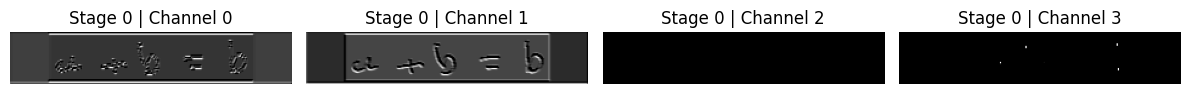

Stage 1 output shape: torch.Size([1, 64, 22, 116])


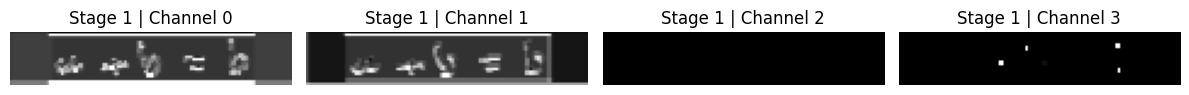

Stage 2 output shape: torch.Size([1, 64, 22, 116])


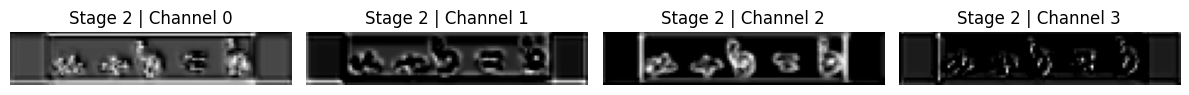

Stage 3 output shape: torch.Size([1, 128, 11, 58])


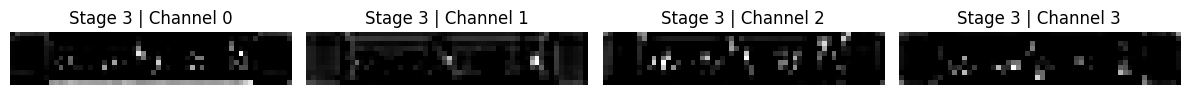

Stage 4 output shape: torch.Size([1, 256, 6, 29])


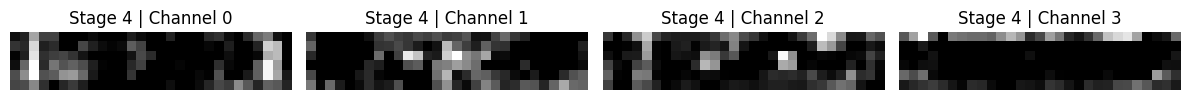

In [15]:
# 取一张图像样本
images, _, _ = next(iter(train_loader))
sample_img = images[0:1].cuda()  # shape: [1, C, H, W]

# 初始化可视化 CNN
viz_cnn = VisualCNN().cuda()
features = viz_cnn(sample_img)

# 可视化每一层输出
for idx, feat in enumerate(features):
    print(f"Stage {idx} output shape: {feat.shape}")
    show_feature_map(feat, f"Stage {idx}")


In [16]:
def show_max_activation(feature_map, title="Max Activation"):
    
    max_activations = torch.max(feature_map[0], dim=0).values.detach().cpu()
    
    plt.figure(figsize=(6, 4))
    plt.imshow(max_activations, cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()


Stage 0 output shape: torch.Size([1, 64, 43, 232])


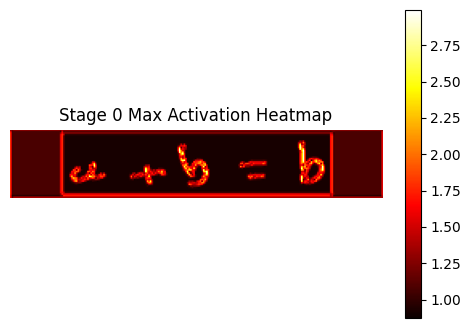

Stage 1 output shape: torch.Size([1, 64, 22, 116])


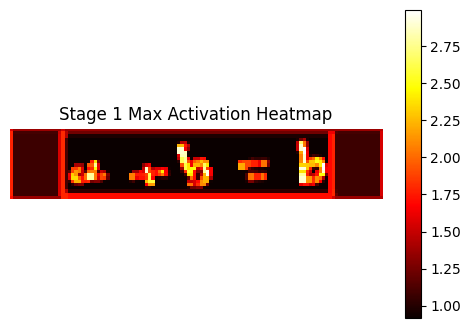

Stage 2 output shape: torch.Size([1, 64, 22, 116])


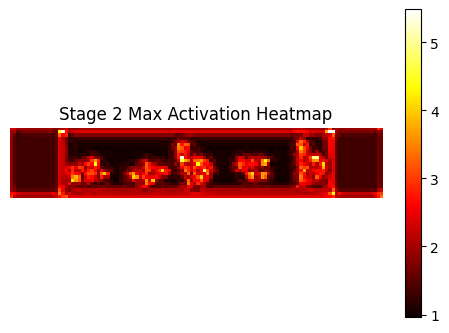

Stage 3 output shape: torch.Size([1, 128, 11, 58])


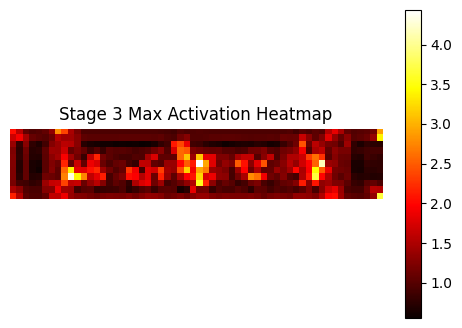

Stage 4 output shape: torch.Size([1, 256, 6, 29])


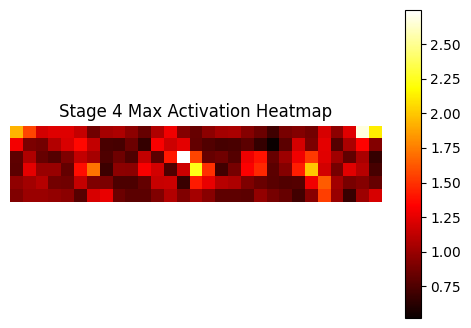

In [17]:
for idx, feat in enumerate(features):
    print(f"Stage {idx} output shape: {feat.shape}")
    show_max_activation(feat, f"Stage {idx} Max Activation Heatmap")


In [18]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=4, max_len=256, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len * 2, d_model))

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, vocab_size)

        nn.init.normal_(self.pos_embedding, std=0.02)

    def forward(self, tgt_input, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None):
        # tgt_input: [B, T]
        tgt_emb = self.token_embedding(tgt_input) + self.pos_embedding[:, :tgt_input.size(1), :]  # [B, T, D]

        # memory: [B, H, W, D] -> [B, HW, D]
        memory = memory.reshape(memory.size(0), -1, memory.size(-1))


        # Decoder output
        output = self.transformer_decoder(
            tgt=tgt_emb,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )
        return self.output_layer(output)  # [B, T, vocab_size]

In [19]:
def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [20]:
class Im2LatexModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, max_seq_len=256):
        super().__init__()
        self.encoder = Encoder(d_model=d_model)
        self.decoder = Decoder(vocab_size=vocab_size, d_model=d_model, max_len=max_seq_len)
        self.max_seq_len = max_seq_len

    def forward(self, images, tgt_input, tgt_mask=None):
        enc_output = self.encoder(images)  # [B, H, W, D]
        logits = self.decoder(tgt_input, enc_output, tgt_mask=tgt_mask)
        return logits  # [B, T, vocab_size]

In [21]:
# 假设你有 batch
images, labels, _ = next(iter(train_loader))
images = images.cuda()
labels = labels.cuda()

# Create input by shifting
tgt_input = labels[:, :-1]
tgt_output = labels[:, 1:]

model = Im2LatexModel(vocab_size=len(token2idx), d_model=256, max_seq_len=max_seq_length).cuda()
tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(images.device)

logits = model(images, tgt_input, tgt_mask)  # [B, T, vocab_size]

print("Decoder output:", logits.shape)

Decoder output: torch.Size([32, 223, 113])


In [22]:
def test_decoder_integrity(model, images, labels, token2idx, idx2token):
    print("=" * 50)
    print("Running Decoder Integrity Tests")
    print("=" * 50)

    device = next(model.parameters()).device
    images, labels = images.to(device), labels.to(device)
    tgt_input = labels[:, :-1]
    tgt_output = labels[:, 1:]
    tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

    # Forward
    logits = model(images, tgt_input, tgt_mask)  # [B, T, vocab_size]

    # Test 1 - Logits stats
    print("\n[1] Logits distribution:")
    print("   mean:", logits.mean().item())
    print("   max :", logits.max().item())
    print("   min :", logits.min().item())

    # Test 2 - Sample Top-K token at t=10
    t = min(10, logits.size(1) - 1)
    sample_logits = logits[0, t]
    probs = torch.softmax(sample_logits, dim=-1)
    topk_probs, topk_idx = torch.topk(probs, k=5)

    print("\n[2] Top-5 tokens at timestep", t)
    for i in range(5):
        print(f"   {idx2token[topk_idx[i].item()]}: {topk_probs[i].item():.4f}")

    # Test 3 - First-step decoder only
    print("\n[3] First-step decoding test")
    start = torch.full((1, 1), token2idx['<s>'], dtype=torch.long).to(device)
    enc_out = model.encoder(images[0:1])
    logits_start = model.decoder(start, enc_out)
    pred = torch.argmax(logits_start, dim=-1)[0, 0].item()
    print(f"   Predicted first token: {idx2token[pred]}")

    # Test 4 - Gradient check
    print("\n[4] Gradient flow check")
    logits_flat = logits.view(-1, logits.size(-1))
    labels_flat = tgt_output.contiguous().view(-1)
    loss_fn = nn.CrossEntropyLoss(ignore_index=token2idx['<pad>'])
    loss = loss_fn(logits_flat, labels_flat)
    loss.backward()

    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"   {name:40s} | grad norm = {param.grad.norm():.4f}")

    print("\nDecoder passed all integrity checks (forward & backward).\n")

In [23]:
images, labels, _ = next(iter(train_loader))
test_decoder_integrity(model, images, labels, token2idx, idx2token)

Running Decoder Integrity Tests

[1] Logits distribution:
   mean: 0.04098084196448326
   max : 2.32029128074646
   min : -2.123798131942749

[2] Top-5 tokens at timestep 10
   a: 0.0269
   \theta: 0.0235
   \exists: 0.0234
   o: 0.0220
   z: 0.0217

[3] First-step decoding test
   Predicted first token: v

[4] Gradient flow check
   encoder.backbone.0.weight                | grad norm = 0.0561
   encoder.backbone.1.weight                | grad norm = 0.0052
   encoder.backbone.1.bias                  | grad norm = 0.0018
   encoder.backbone.4.0.conv1.weight        | grad norm = 0.0147
   encoder.backbone.4.0.bn1.weight          | grad norm = 0.0033
   encoder.backbone.4.0.bn1.bias            | grad norm = 0.0032
   encoder.backbone.4.0.conv2.weight        | grad norm = 0.0113
   encoder.backbone.4.0.bn2.weight          | grad norm = 0.0041
   encoder.backbone.4.0.bn2.bias            | grad norm = 0.0018
   encoder.backbone.4.1.conv1.weight        | grad norm = 0.0129
   encoder.backbo

In [24]:
def create_loss_function(token2idx):
    ignore_index = token2idx['<pad>']
    return nn.CrossEntropyLoss(ignore_index=ignore_index)

In [25]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for images, labels, _ in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        tgt_input = labels[:, :-1]
        tgt_output = labels[:, 1:]

        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        optimizer.zero_grad()
        logits = model(images, tgt_input, tgt_mask)

        logits = logits.view(-1, logits.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)

        loss = loss_fn(logits, tgt_output)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [26]:
@torch.no_grad()
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0

    for images, labels, _ in tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        tgt_input = labels[:, :-1]
        tgt_output = labels[:, 1:]

        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        logits = model(images, tgt_input, tgt_mask)
        logits = logits.view(-1, logits.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)

        loss = loss_fn(logits, tgt_output)
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [27]:
def fit(model, train_loader, val_loader, token2idx, epochs=10, lr=1e-4, device="cuda"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = create_loss_function(token2idx)
    best_val_loss = float('inf')
    save_path = "best_model.pt"

    writer = SummaryWriter(log_dir="runs/im2latex")

    train_losses = []
    val_losses = []

    print("\nMeasuring Initial Loss...")
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        images, labels, _ = batch
        images, labels = images.to(device), labels.to(device)

        tgt_input = labels[:, :-1]
        tgt_output = labels[:, 1:]
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        logits = model(images, tgt_input, tgt_mask)
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
        print(f"Initial Loss (on val batch): {loss.item():.4f}")

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model to {save_path}")

    writer.close()

    # Plot loss curve
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_curve.png")
    plt.show()
    print("Saved loss curve to loss_curve.png")


Measuring Initial Loss...
Initial Loss (on val batch): 4.8908

Epoch 1/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 2.4277 | Val Loss: 1.9678
Saved best model to best_model.pt

Epoch 2/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.8725 | Val Loss: 1.7656
Saved best model to best_model.pt

Epoch 3/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.6618 | Val Loss: 1.6283
Saved best model to best_model.pt

Epoch 4/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.4732 | Val Loss: 1.3782
Saved best model to best_model.pt

Epoch 5/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.2943 | Val Loss: 1.2174
Saved best model to best_model.pt

Epoch 6/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 1.1272 | Val Loss: 1.0438
Saved best model to best_model.pt

Epoch 7/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.9635 | Val Loss: 0.8915
Saved best model to best_model.pt

Epoch 8/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.8178 | Val Loss: 0.7914
Saved best model to best_model.pt

Epoch 9/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.7053 | Val Loss: 0.6748
Saved best model to best_model.pt

Epoch 10/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.6068 | Val Loss: 0.6286
Saved best model to best_model.pt

Epoch 11/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.5265 | Val Loss: 0.5408
Saved best model to best_model.pt

Epoch 12/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.4667 | Val Loss: 0.5267
Saved best model to best_model.pt

Epoch 13/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.4120 | Val Loss: 0.4766
Saved best model to best_model.pt

Epoch 14/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.3671 | Val Loss: 0.4628
Saved best model to best_model.pt

Epoch 15/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.3317 | Val Loss: 0.4876

Epoch 16/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.3051 | Val Loss: 0.4615
Saved best model to best_model.pt

Epoch 17/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2706 | Val Loss: 0.4111
Saved best model to best_model.pt

Epoch 18/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2458 | Val Loss: 0.4505

Epoch 19/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2302 | Val Loss: 0.3922
Saved best model to best_model.pt

Epoch 20/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.2100 | Val Loss: 0.3720
Saved best model to best_model.pt

Epoch 21/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1896 | Val Loss: 0.3731

Epoch 22/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1826 | Val Loss: 0.3897

Epoch 23/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1598 | Val Loss: 0.3703
Saved best model to best_model.pt

Epoch 24/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1564 | Val Loss: 0.3543
Saved best model to best_model.pt

Epoch 25/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1357 | Val Loss: 0.3564

Epoch 26/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1263 | Val Loss: 0.3525
Saved best model to best_model.pt

Epoch 27/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1184 | Val Loss: 0.3585

Epoch 28/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1110 | Val Loss: 0.3441
Saved best model to best_model.pt

Epoch 29/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1024 | Val Loss: 0.3579

Epoch 30/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.1026 | Val Loss: 0.3688

Epoch 31/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0942 | Val Loss: 0.3484

Epoch 32/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0867 | Val Loss: 0.3365
Saved best model to best_model.pt

Epoch 33/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0855 | Val Loss: 0.3508

Epoch 34/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0831 | Val Loss: 0.3627

Epoch 35/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0753 | Val Loss: 0.3471

Epoch 36/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0734 | Val Loss: 0.3469

Epoch 37/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0672 | Val Loss: 0.3616

Epoch 38/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0657 | Val Loss: 0.3648

Epoch 39/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0669 | Val Loss: 0.3857

Epoch 40/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0660 | Val Loss: 0.3508

Epoch 41/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0569 | Val Loss: 0.3555

Epoch 42/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0573 | Val Loss: 0.3456

Epoch 43/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0513 | Val Loss: 0.3603

Epoch 44/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0530 | Val Loss: 0.3644

Epoch 45/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0487 | Val Loss: 0.3594

Epoch 46/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0517 | Val Loss: 0.3696

Epoch 47/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0520 | Val Loss: 0.3879

Epoch 48/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0484 | Val Loss: 0.3607

Epoch 49/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0431 | Val Loss: 0.3610

Epoch 50/50


Training:   0%|          | 0/267 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/58 [00:00<?, ?it/s]

Train Loss: 0.0395 | Val Loss: 0.3903


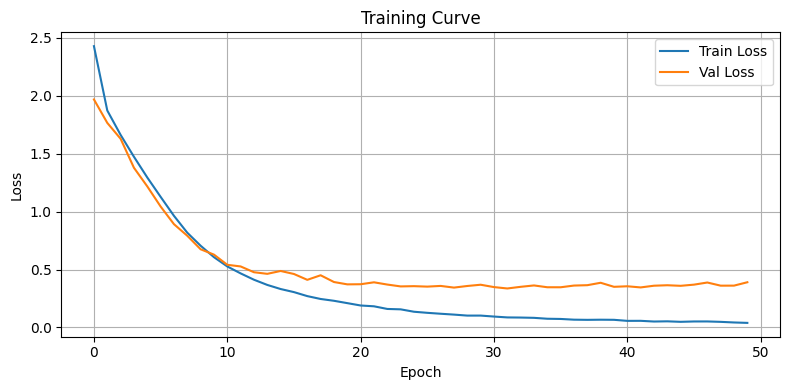

Saved loss curve to loss_curve.png


In [28]:
model = Im2LatexModel(
    vocab_size=len(token2idx),
    d_model=256,
    max_seq_len=max_seq_length
).to("cuda")

fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    token2idx=token2idx,
    epochs=50,
    lr=1e-4,
    device="cuda"
)

In [63]:
def beam_search_decode(model, image, token2idx, idx2token, beam_width=3, max_len=256, device="cuda"):
    model.eval()
    
    if not image.is_cuda:
        image = image.to(device)
    
    with torch.no_grad():
        memory = model.encoder(image.unsqueeze(0))  # [1, C, H, W]
        memory = memory.expand(beam_width, *memory.shape[1:])  # [beam, C, H, W]

        sequences = [[token2idx['<s>']] for _ in range(beam_width)]
        scores = torch.zeros(beam_width, device=device)
        completed = []

        for step in range(max_len):
            all_candidates = []
            for i, seq in enumerate(sequences):
                if len(seq) > 1 and seq[-1] == token2idx['</s>']:
                    completed.append((seq, scores[i].item()))
                    continue

                tgt_input = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
                tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
                output = model.decoder(tgt_input, memory[i:i+1], tgt_mask)
                probs = torch.log_softmax(output[0, -1], dim=-1)  # log-probs

                topk_probs, topk_idx = torch.topk(probs, beam_width)
                for j in range(beam_width):
                    candidate = seq + [topk_idx[j].item()]
                    score = scores[i] + topk_probs[j]
                    all_candidates.append((candidate, score))

            all_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
            sequences = [cand[0] for cand in all_candidates]
            scores = torch.tensor([cand[1] for cand in all_candidates], device=device)

        completed += list(zip(sequences, scores.tolist()))
        completed = sorted(completed, key=lambda x: x[1], reverse=True)

        best_seq = completed[0][0]
        return [idx2token[idx] for idx in best_seq[1:-1] if idx in idx2token]


In [ ]:
@torch.no_grad()
def evaluate_model_with_beam(model, dataset, token2idx, idx2token, num_samples, beam_width=3, max_len=256, visualize=True):
    model.eval()
    correct = 0
    total = 0

    device = next(model.parameters()).device

    def tokens_to_str(tokens):
        return ''.join(t for t in tokens if t not in ['<s>', '</s>', '<pad>'])

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)  # 🛠 把图片也搬上GPU
        
        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device)
        true_tokens = [idx2token[idx.item()] for idx in label if idx.item() != token2idx['<pad>']]

        pred_str = tokens_to_str(pred_tokens)
        true_str = tokens_to_str(true_tokens)

        match = pred_str == true_str
        correct += int(match)
        total += 1

        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(12, 3))
            axes[0].imshow(image.permute(1, 2, 0).squeeze().cpu(), cmap='gray')
            axes[0].set_title("Input Image")
            axes[0].axis("off")

            axes[1].text(0.5, 0.7, f"GT: ${true_str}$", ha='center', fontsize=12)
            axes[1].text(0.5, 0.3, f"Pred: ${pred_str}$", ha='center', fontsize=12, color=('green' if match else 'red'))
            axes[1].axis("off")
            plt.show()

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    acc = correct / total
    print(f"\nBeam Search Accuracy (exact match): {acc * 100:.2f}%")
    return acc


In [67]:
evaluate_model_with_beam(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3,
    visualize=False
)

Processed 100/1826 samples...
Processed 200/1826 samples...
Processed 300/1826 samples...
Processed 400/1826 samples...
Processed 500/1826 samples...
Processed 600/1826 samples...
Processed 700/1826 samples...
Processed 800/1826 samples...
Processed 900/1826 samples...
Processed 1000/1826 samples...
Processed 1100/1826 samples...
Processed 1200/1826 samples...
Processed 1300/1826 samples...
Processed 1400/1826 samples...
Processed 1500/1826 samples...
Processed 1600/1826 samples...
Processed 1700/1826 samples...
Processed 1800/1826 samples...

Beam Search Accuracy (exact match): 45.62%


0.45618838992332966

In [ ]:
def evaluate_token_level_accuracy(model, dataset, token2idx, idx2token, num_samples=50, beam_width=3, max_len=256):
    model.eval()
    total_tokens = 0
    correct_tokens = 0

    device = next(model.parameters()).device
    print(f"Evaluating on device: {device}")

    def strip_tokens(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip_tokens(pred_tokens)
        true = strip_tokens(true_tokens)

        for p, t in zip(pred, true):
            total_tokens += 1
            if p == t:
                correct_tokens += 1

        total_tokens += abs(len(pred) - len(true))

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0.0
    print(f"Token-level accuracy: {accuracy * 100:.2f}%")
    return accuracy


In [ ]:
accuracy = evaluate_token_level_accuracy(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3
)

Evaluating on device: cuda:0
Processed 100/1826 samples...
Processed 200/1826 samples...
Processed 300/1826 samples...
Processed 400/1826 samples...
Processed 500/1826 samples...
Processed 600/1826 samples...
Processed 700/1826 samples...
Processed 800/1826 samples...
Processed 900/1826 samples...
Processed 1000/1826 samples...
Processed 1100/1826 samples...
Processed 1200/1826 samples...
Processed 1300/1826 samples...
Processed 1400/1826 samples...
Processed 1500/1826 samples...
Processed 1600/1826 samples...
Processed 1700/1826 samples...
Processed 1800/1826 samples...
Token-level accuracy: 68.29%


In [68]:
@torch.no_grad()
def evaluate_edit_distance(model, dataset, token2idx, idx2token, num_samples=50, beam_width=3, max_len=256):
    model.eval()
    total_ned = 0.0
    count = 0

    device = next(model.parameters()).device

    def strip_tokens(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip_tokens(pred_tokens)
        true = strip_tokens(true_tokens)

        pred_str = ' '.join(pred)
        true_str = ' '.join(true)

        if len(true_str.strip()) == 0:
            continue

        lev_dist = Levenshtein.distance(pred_str, true_str)
        max_len_str = max(len(pred_str), len(true_str))
        ned = 1 - lev_dist / max_len_str
        total_ned += ned
        count += 1

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    avg_ned = total_ned / count if count > 0 else 0.0
    print(f"Normalized Edit Distance (NED): {avg_ned * 100:.2f}%")
    return avg_ned


In [69]:
evaluate_edit_distance(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3
)

Processed 100/1826 samples...
Processed 200/1826 samples...
Processed 300/1826 samples...
Processed 400/1826 samples...
Processed 500/1826 samples...
Processed 600/1826 samples...
Processed 700/1826 samples...
Processed 800/1826 samples...
Processed 900/1826 samples...
Processed 1000/1826 samples...
Processed 1100/1826 samples...
Processed 1200/1826 samples...
Processed 1300/1826 samples...
Processed 1400/1826 samples...
Processed 1500/1826 samples...
Processed 1600/1826 samples...
Processed 1700/1826 samples...
Processed 1800/1826 samples...
Normalized Edit Distance (NED): 86.82%


0.8682135826428554

In [72]:
@torch.no_grad()
def export_predictions_to_csv(model, dataset, token2idx, idx2token, beam_width=3, max_len=256, num_samples=100, output_file="prediction_results.csv"):
    model.eval()
    results = []

    device = next(model.parameters()).device

    def strip_tokens(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip_tokens(pred_tokens)
        true = strip_tokens(true_tokens)

        pred_str = ' '.join(pred)
        true_str = ' '.join(true)

        sentence_match = pred == true

        if len(true) > 0:
            match_count = sum(p == t for p, t in zip(pred, true))
            token_accuracy = match_count / len(true)
        else:
            token_accuracy = 0.0

        if len(true_str.strip()) > 0:
            lev = Levenshtein.distance(pred_str, true_str)
            ned = 1 - lev / max(len(pred_str), len(true_str))
        else:
            ned = 0.0

        results.append({
            "index": i,
            "true_latex": true_str,
            "pred_latex": pred_str,
            "sentence_match": sentence_match,
            "token_accuracy(%)": round(token_accuracy * 100, 2),
            "normalized_edit_distance(%)": round(ned * 100, 2)
        })

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"Saved prediction results to: {output_file}")
    return df


In [73]:
df_results = export_predictions_to_csv(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    beam_width=3,
    num_samples=len(test_dataset),
    output_file="latex_predictions.csv"
)

Processed 100/1826 samples...
Processed 200/1826 samples...
Processed 300/1826 samples...
Processed 400/1826 samples...
Processed 500/1826 samples...
Processed 600/1826 samples...
Processed 700/1826 samples...
Processed 800/1826 samples...
Processed 900/1826 samples...
Processed 1000/1826 samples...
Processed 1100/1826 samples...
Processed 1200/1826 samples...
Processed 1300/1826 samples...
Processed 1400/1826 samples...
Processed 1500/1826 samples...
Processed 1600/1826 samples...
Processed 1700/1826 samples...
Processed 1800/1826 samples...
Saved prediction results to: latex_predictions.csv


In [77]:
def render_prediction_comparison(image_tensor, true_latex, pred_latex):
    plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # 图像
    ax0 = plt.subplot(gs[0])
    ax0.imshow(image_tensor.permute(1, 2, 0).squeeze(), cmap='gray')
    ax0.set_title("Input Image")
    ax0.axis("off")

    # GT LaTeX
    ax1 = plt.subplot(gs[1])
    ax1.text(0.5, 0.5, f"${true_latex}$", fontsize=18, ha='center', va='center')
    ax1.set_title("Ground Truth")
    ax1.axis("off")

    # Prediction LaTeX
    ax2 = plt.subplot(gs[2])
    ax2.text(0.5, 0.5, f"${pred_latex}$", fontsize=18, ha='center', va='center')
    ax2.set_title("Prediction")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

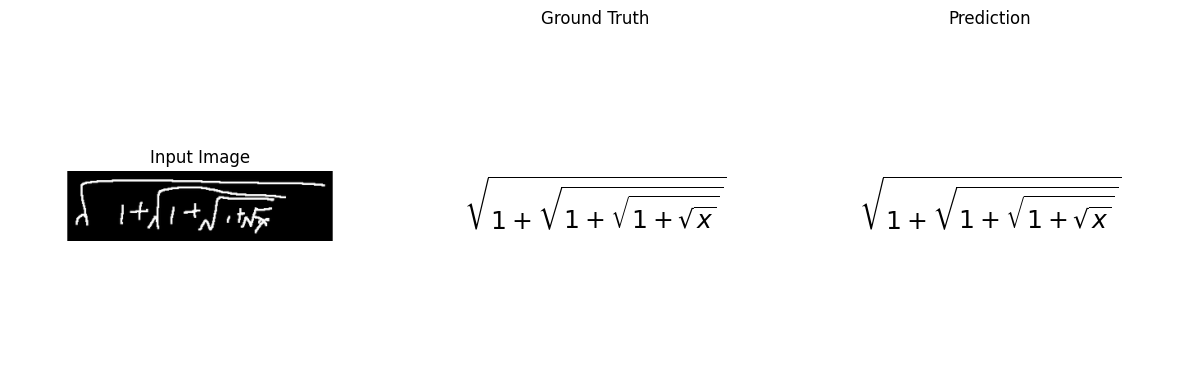

In [79]:
# 选择一个样本，比如第 7 个
index = 7
image, label = test_dataset[index]

# 预测
pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width=3)
true_tokens = [idx2token[idx.item()] for idx in label]

# 去除特殊符号
def clean(toks): return ''.join(t for t in toks if t not in ['<s>', '</s>', '<pad>'])
true_str = clean(true_tokens)
pred_str = clean(pred_tokens)

# 渲染对比图
render_prediction_comparison(image, true_str, pred_str)


In [88]:
@torch.no_grad()
def build_confusion_matrix_gpu(model, dataset, token2idx, idx2token,
                                num_samples=200, beam_width=3, max_len=256, top_k_tokens=30):
    model.eval()
    true_labels = []
    pred_labels = []

    device = next(model.parameters()).device

    def strip(tokens):
        return [t for t in tokens if t not in ['<pad>', '<s>', '</s>']]

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.to(device)  # 🔥 图片搬到GPU

        pred_tokens = beam_search_decode(model, image, token2idx, idx2token, beam_width, max_len, device=device)
        true_tokens = [idx2token[idx.item()] for idx in label]

        pred = strip(pred_tokens)
        true = strip(true_tokens)

        min_len = min(len(pred), len(true))
        true_labels.extend(true[:min_len])
        pred_labels.extend(pred[:min_len])

        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{num_samples} samples...")

    # 统计 Top-K token
    all_tokens = Counter(true_labels + pred_labels)
    most_common = [tok for tok, _ in all_tokens.most_common(top_k_tokens)]
    most_common_set = set(most_common)

    def map_tok(tok):
        return tok if tok in most_common_set else 'other'

    mapped_true = [map_tok(tok) for tok in true_labels]
    mapped_pred = [map_tok(tok) for tok in pred_labels]

    labels_sorted = sorted(set(mapped_true + mapped_pred))

    cm = confusion_matrix(mapped_true, mapped_pred, labels=labels_sorted)

    # 绘制混淆矩阵
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels_sorted, yticklabels=labels_sorted)
    plt.xlabel("Predicted Token")
    plt.ylabel("Ground Truth Token")
    plt.title(f"Confusion Matrix (Top {top_k_tokens} Tokens + 'other')")
    plt.tight_layout()
    plt.show()

    return cm, labels_sorted, true_labels, pred_labels


In [89]:
def analyze_top_confusions(true_labels, pred_labels, top_k=10):
    """
    分析最常见的混淆对
    """
    assert len(true_labels) == len(pred_labels)

    confusions = Counter()

    for t, p in zip(true_labels, pred_labels):
        if t != p:
            confusions[(t, p)] += 1

    most_common_confusions = confusions.most_common(top_k)

    print(f"\nTop-{top_k} Most Common Confusions:")
    for (true_tok, pred_tok), count in most_common_confusions:
        print(f"  '{true_tok}' → '{pred_tok}' : {count} times")

    return most_common_confusions


Processed 100/1826 samples...
Processed 200/1826 samples...
Processed 300/1826 samples...
Processed 400/1826 samples...
Processed 500/1826 samples...
Processed 600/1826 samples...
Processed 700/1826 samples...
Processed 800/1826 samples...
Processed 900/1826 samples...
Processed 1000/1826 samples...
Processed 1100/1826 samples...
Processed 1200/1826 samples...
Processed 1300/1826 samples...
Processed 1400/1826 samples...
Processed 1500/1826 samples...
Processed 1600/1826 samples...
Processed 1700/1826 samples...
Processed 1800/1826 samples...


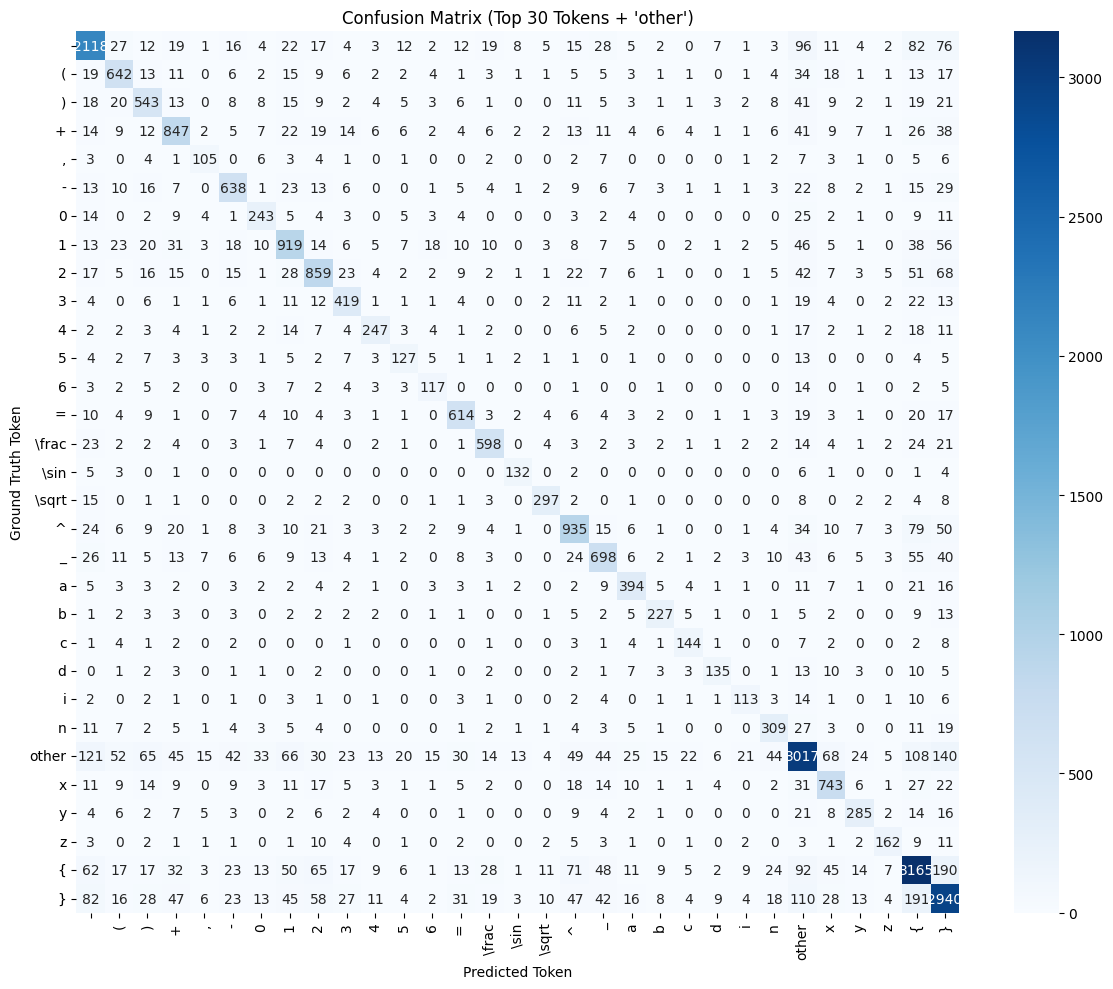


Top-15 Most Common Confusions:
  '}' → '{' : 191 times
  '{' → '}' : 190 times
  '}' → ' ' : 82 times
  ' ' → '{' : 82 times
  '^' → '{' : 79 times
  ' ' → '}' : 76 times
  '{' → '^' : 71 times
  '2' → '}' : 68 times
  '{' → '2' : 65 times
  '{' → ' ' : 62 times
  '}' → '2' : 58 times
  '1' → '}' : 56 times
  '_' → '{' : 55 times
  '2' → '{' : 51 times
  '^' → '}' : 50 times


In [ ]:
cm, labels_sorted, true_labels, pred_labels = build_confusion_matrix_gpu(
    model=model,
    dataset=test_dataset,
    token2idx=token2idx,
    idx2token=idx2token,
    num_samples=len(test_dataset),
    beam_width=3,
    max_len=256,
    top_k_tokens=30
)

top_confusions = analyze_top_confusions(true_labels, pred_labels, top_k=15)